# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import random

import warnings
warnings.filterwarnings('ignore') 

In [2]:
# Загрузка данных
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
# Изучение df0
display(df0.info())
df0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
# Изучение df1
display(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
# Изучение df1
display(df0.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<b> Cтолбцы всех датафреймов имеют корректные типы данных и не содержат пропусков

In [6]:
# Проверка на наличие дубликатов
display(df0.duplicated().sum())
display(df1.duplicated().sum())
display(df2.duplicated().sum())

0

0

0

<b> По всем данным полных дубликатов нет

In [7]:
# Проверка данных на уникальность
df0.nunique()

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

In [8]:
df1.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

In [9]:
df1['product'].value_counts()

53.906522     8472
26.953261     8468
84.038886     8431
57.085625     8390
3.179103      8337
80.859783     8320
30.132364     8306
134.766305    8304
110.992147    8303
0.000000      8235
137.945408    8233
107.813044    8201
Name: product, dtype: int64

<b> В датафрейме всего 12 вариантов значений объемов запасов, при этом прочие столбцы различаются. Возможно данный датафрейм заполнялся с помощью алгоритма и требуют более глубокого изучения

In [10]:
df2.nunique()

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

<b> В целом по всем датафреймам видно, что присутсвуют несколько неуникальных значений идентификаторов скважин, но они имеют разные признаки. </b> Можно предположить, что значения некоторых скважин необходимо было повторно перепроверить, из-за чего и возникли дубликаты.

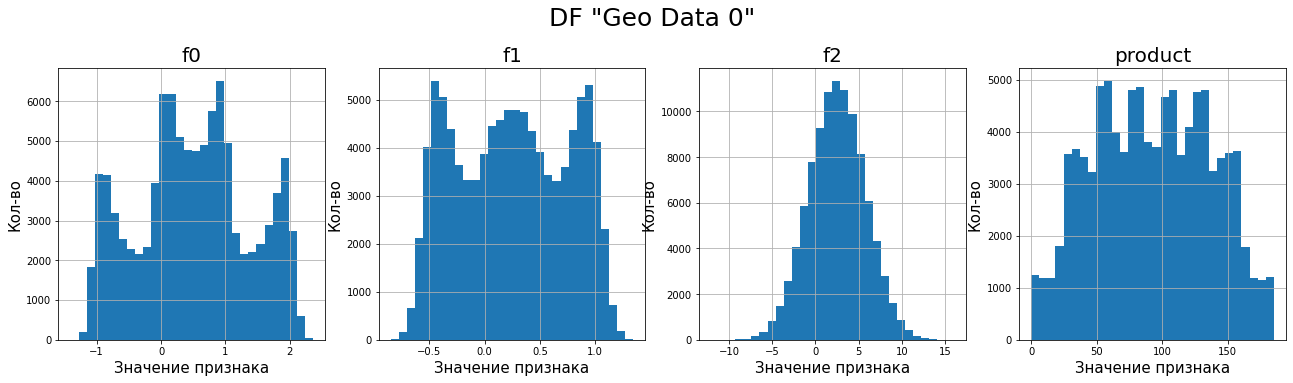

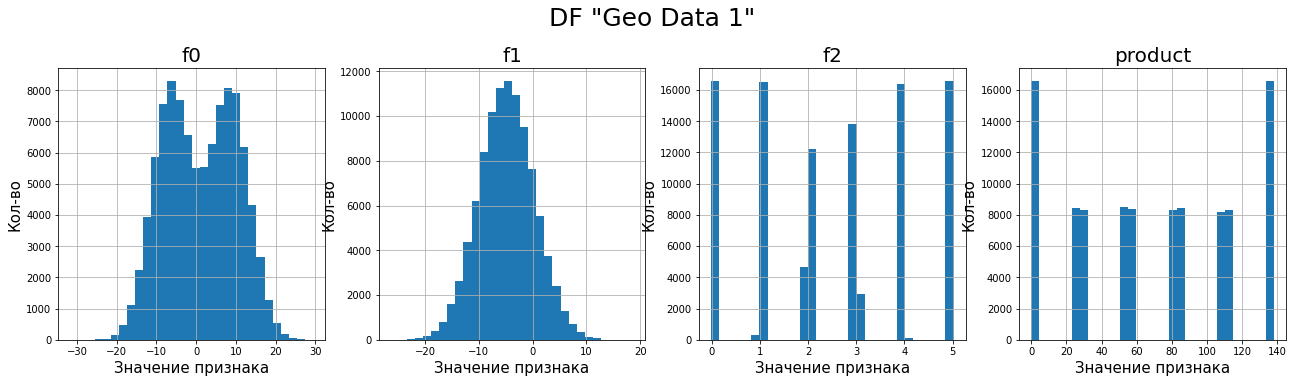

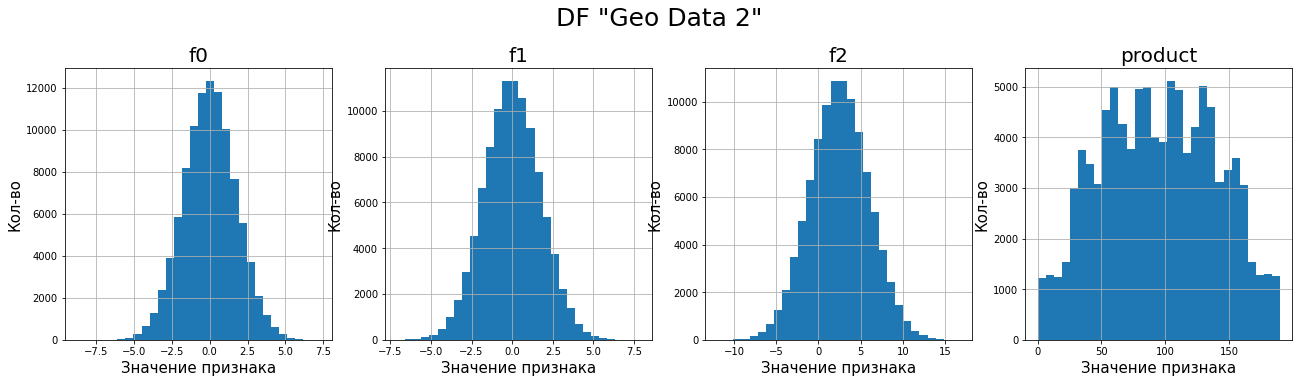

In [11]:
# Т.к. id скважин уникально и не численно, выводим для анализа только значение параметров каждого датафрейма

df0.name = 'Geo Data 0'   
df1.name = 'Geo Data 1'
df2.name = 'Geo Data 2'
dfs = [df0, df1, df2]
for df in dfs:
    f = plt.figure(figsize=(22, 5))
    t = f.suptitle('DF "{}"'.format(df.name), fontsize=25)
    t.set_position([.5, 1.05])
    rows = 1
    cols = 4
    counter = 1
    for column in ['f0', 'f1', 'f2', 'product']:
        ax = plt.subplot(rows, cols, counter)
        plt.xlabel('Значение признака', fontsize=15)
        plt.ylabel('Кол-во', fontsize=15)
        ax.set_title(column, fontsize=20)
        df[column].hist(bins=30)
        counter += 1
    print('\n')
    plt.show()

<b> У датафреймов geo_data_0 (признаки f0 и f1) и geo_data_1 (признак f0) имееют несколько вершин в своих распределениях. Не имея более подробной информации о сути признаков, понять природу отклонения не представляется возможным.

Из графиков видно, что данные имеют разный масштаб, который необходимо будет в дальнейшем масштабировать.

<b> Для работы с моделью информация о идентификаторе скважины является избыточной и её стоит удалить.

In [12]:
for df in dfs:
    df.drop('id', axis=1, inplace=True)

<b>Предвартельные выводы по предобработке данных:</b>

- Данные не содержат пропусков;
- Данные не имеют полных дубликатов;
- Данные необходимо будет масштабировать, для дальнейшего использования.

## Обучение и проверка модели

### Разделение датафреймов на две выборки: обучающую ( 75%) и валидационную ( 25%)

In [13]:
#словарь 'features' будет содержать имя датафрейма и набор соответствующих ему признаков
features = {}
for df in dfs:
    features[df.name] = df.drop('product', axis=1)

#словарь 'target' будет содержать имя датафрейма и набор целевого признака
target = {}
for df in dfs:
    target[df.name] = df['product']

#создание обучающих и валидационных выборок
features_train = {}
features_valid = {}
target_train = {}
target_valid = {}

for df in dfs:
    features_train[df.name], features_valid[df.name], target_train[df.name], target_valid[df.name] = train_test_split(
        features[df.name], target[df.name], test_size=0.25, random_state=12345, shuffle=True)


### Проведем масштабирование признаков

In [14]:
columns = ['f0', 'f1', 'f2']
for df in dfs:
    scaler = StandardScaler()
    scaler.fit(features_train[df.name])
    features_train[df.name][columns] = scaler.transform(features_train[df.name][columns])
    features_valid[df.name][columns] = scaler.transform(features_valid[df.name][columns])

Проверка масштабирования:

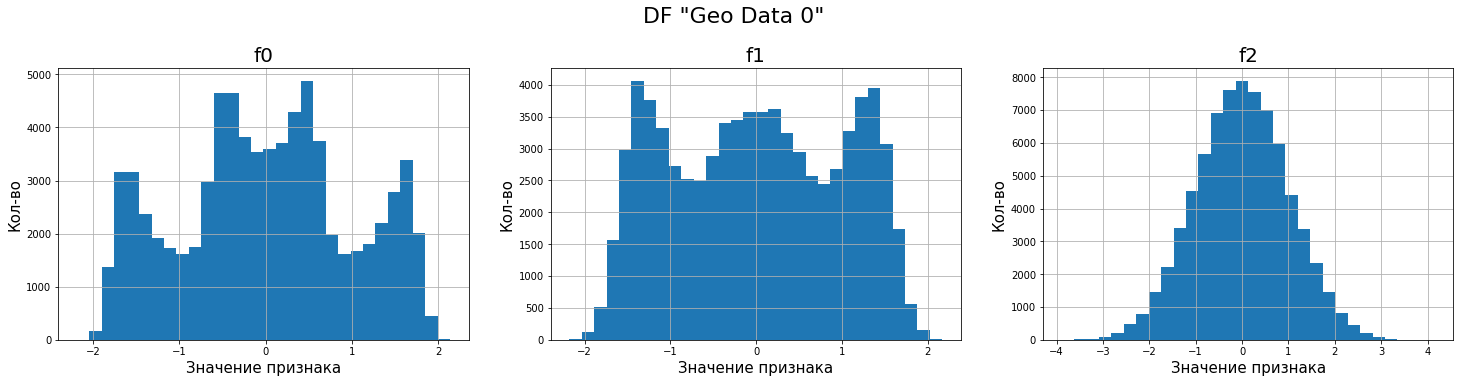

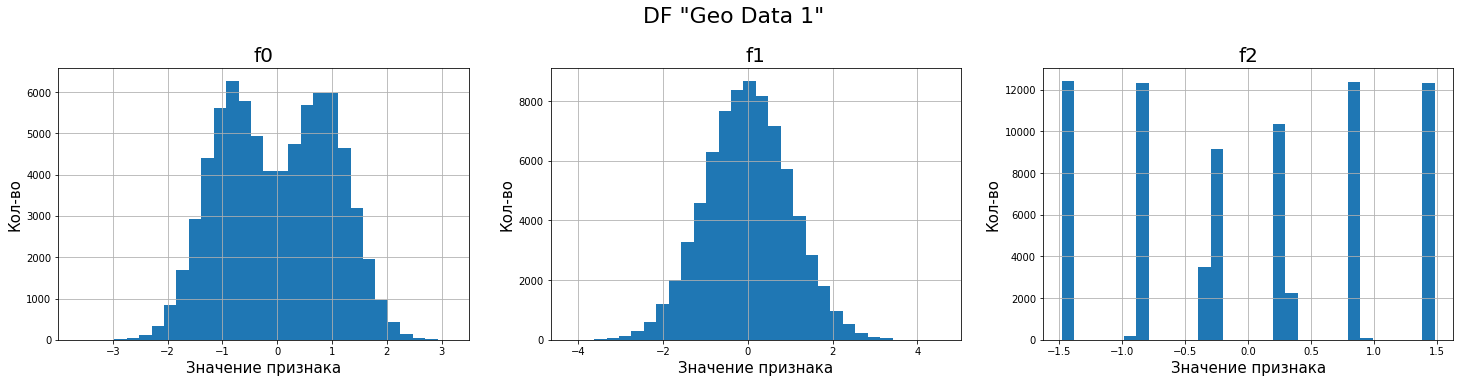

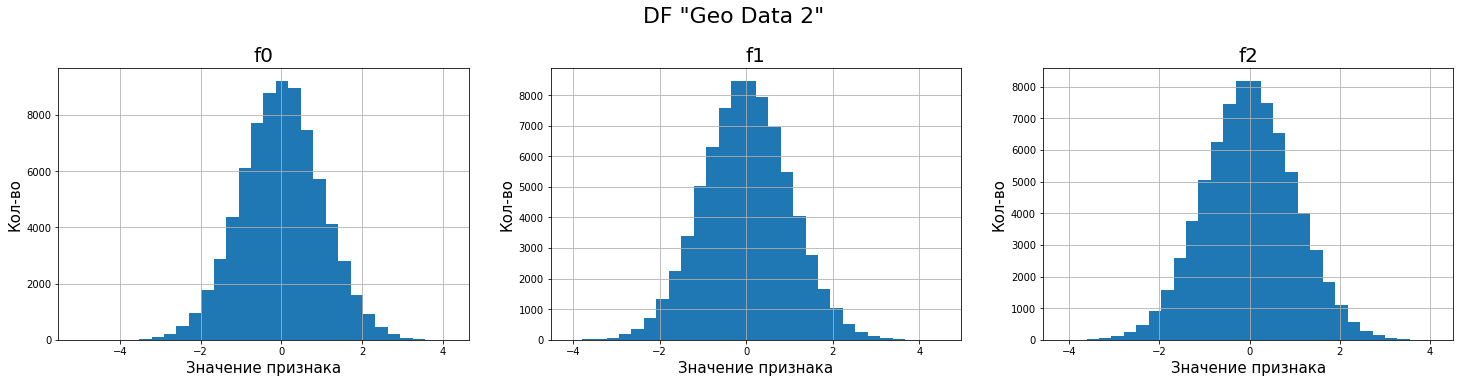

In [15]:
for df in dfs:
    f = plt.figure(figsize=(25, 5))
    t = f.suptitle('DF "{}"'.format(df.name), fontsize=22)
    t.set_position([.5, 1.05])
    rows = 1
    cols = 3
    counter = 1
    for column in ['f0', 'f1', 'f2']:
        ax = plt.subplot(rows, cols, counter)
        plt.xlabel('Значение признака', fontsize=15)
        plt.ylabel('Кол-во', fontsize=15)
        ax.set_title(column, fontsize=20)
        features_train[df.name][column].hist(bins=30)
        counter += 1
    print('\n')
    plt.show()

### Обучение модели

In [16]:
#Словари для хранения предсказаний/таргетов/признаков (значение словаря) по соответствующему датафрейму (ключ словаря)
predicted_valid = {}
predicted_valid200 = {}
target_valid200 = {}
features_valid200 = {}
model = {}

for df in dfs:
    model[df.name] = LinearRegression()
    model[df.name].fit(features_train[df.name], target_train[df.name])
    predicted_valid[df.name] = pd.Series(data=model[df.name].predict(features_valid[df.name]),
                                         index=features_valid[df.name].index)
    
   
    predicted_valid_mean = predicted_valid[df.name].mean()
    rmse = mean_squared_error(target_valid[df.name], predicted_valid[df.name]) ** 0.5
    r2 = r2_score(target_valid[df.name], predicted_valid[df.name])
    
    print('Регион "{}"'.format(df.name))
    print('Средний запас сырья скважин:                     {:.3f} тыс.'. format(predicted_valid_mean))
    print('RMSE:                                            {:.3f} тыс.'. format(rmse))
    print('Коэффициент R2 (по всей валидационной выборке):  {:.2%}'. format(r2)) 
    print('\n')

Регион "Geo Data 0"
Средний запас сырья скважин:                     92.593 тыс.
RMSE:                                            37.579 тыс.
Коэффициент R2 (по всей валидационной выборке):  27.99%


Регион "Geo Data 1"
Средний запас сырья скважин:                     68.729 тыс.
RMSE:                                            0.893 тыс.
Коэффициент R2 (по всей валидационной выборке):  99.96%


Регион "Geo Data 2"
Средний запас сырья скважин:                     94.965 тыс.
RMSE:                                            40.030 тыс.
Коэффициент R2 (по всей валидационной выборке):  20.52%




### Вывод

- Модели обученные для Geo Data 0 и Geo Data 2, имеют слабые показатели предсказания (т.к. коэффициент детерминации (R2) низкий).
- В регионе Geo Data 1 наименьшее количество предсказанного сырья, но при этом коэффициент детерминации высокий, что свидетельствует о хорошей обученности модели на этих данных.

## Подготовка к расчёту прибыли

<b>Определение ключевых параметров для дальнейшего исследования

In [17]:
X = 500 # количество исследуемых точек
B = 200 # количество лучших скважин
T_C = 10000000000 # бюджет на разработку скважин
REV = 450000 # доход с каждой единицы продукта составляет 450 тыс. рублей
LOSS_P = 0.025 # допустимая вероятность убытков

<b> Рассчет минимального объёма сырья для безубыточной разработки скважины.

In [18]:
t_c_b = T_C/B #Делим весь бюджет на кол-во разведываемых скважин
nec_prod = t_c_b/REV
print('Необходимый минимальный объём сырья в скважине: {:.2f} тыс. баррелей'.
      format(nec_prod))

Необходимый минимальный объём сырья в скважине: 111.11 тыс. баррелей


<b> Вывод</b><br>
- Среднее количество сырья во всех регионах выше минимально объема (точки безубыточности). 
- Из представленных регионов, наибольшие средние показатели объема имеет Geo Data 0.

## Создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [19]:
def t_prof(data, region):
    features = data.drop('product', axis=1)
    targets = data['product']
    predictions = model[region].predict(features)
    predictions = pd.Series(predictions, index=features.index)
    sel_oil = predictions.sort_values(ascending=False).head(200).index
    revenue = targets.loc[sel_oil].sum() * REV
    costs = T_C
    profit = revenue - costs
    return profit

## Расчёт прибыли и рисков 

### Распределение прибыли по регионам

In [20]:
state = np.random.RandomState(12345)
BOOTSTRAP_SAMPLES = 1000 

values = {}
for df in dfs:
    values[df.name] = []

for df in dfs:
    for i in range(BOOTSTRAP_SAMPLES):
        df_j=features_valid[df.name].join(target_valid[df.name])
        subsample = df_j.sample(n=500, replace=False, random_state=state)
        values[df.name].append(t_prof(data=subsample, region=df.name))
    values[df.name] = pd.Series(values[df.name])

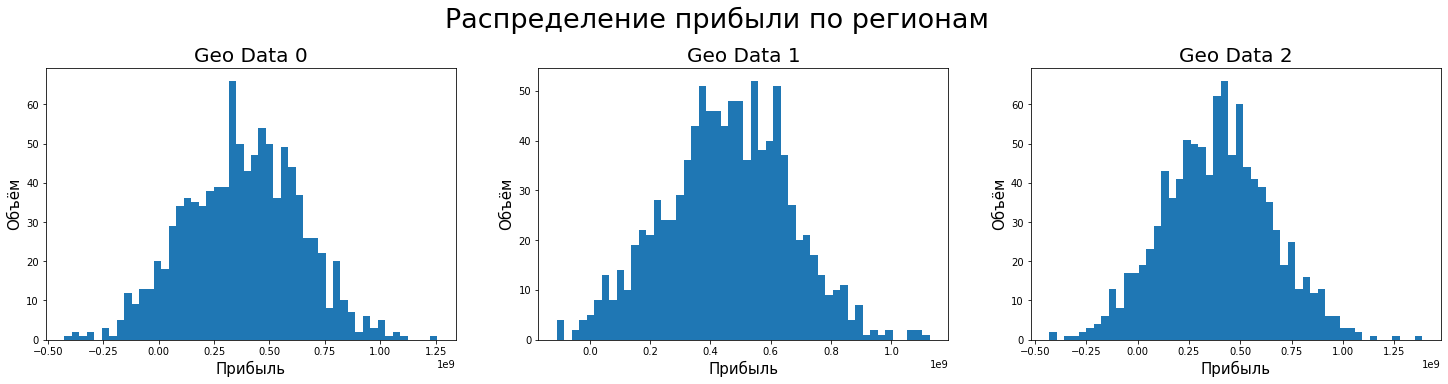

In [21]:
f = plt.figure(figsize=(25, 5))
t = f.suptitle('Распределение прибыли по регионам \n', fontsize=27, )
t.set_position([.5, 1.05])

rows = 1
cols = 3
counter = 1
for df in dfs:
    ax = plt.subplot(rows, cols, counter)
    plt.xlabel('Прибыль', fontsize=15)
    plt.ylabel('Объём', fontsize=15)
    ax.set_title(df.name, fontsize=20)
    plt.hist(values[df.name], density=False, bins=50)
    counter += 1
plt.show()

### Cредняя прибыль в каждом регионе

In [22]:
for df in dfs:
    prof_mean = values[df.name].mean() / 1000000
    print('Средняя прибыль в "{}": {:.2f} млн.руб.'.format(df.name, prof_mean))

Средняя прибыль в "Geo Data 0": 380.71 млн.руб.
Средняя прибыль в "Geo Data 1": 454.79 млн.руб.
Средняя прибыль в "Geo Data 2": 389.22 млн.руб.


### Доверительный интервал

In [23]:
for df in dfs:
    lower = values[df.name].quantile(0.025) / 1000000
    upper = values[df.name].quantile(0.975) / 1000000 #доверительный интервал 95% от всех значений прибыли
    print('Доверительный интервал для средней прибыли в "{}": [{:.2f}, {:.2f}] (млн. руб.)'.
          format(df.name, lower, upper))

Доверительный интервал для средней прибыли в "Geo Data 0": [-126.95, 879.61] (млн. руб.)
Доверительный интервал для средней прибыли в "Geo Data 1": [46.73, 840.21] (млн. руб.)
Доверительный интервал для средней прибыли в "Geo Data 2": [-115.61, 906.51] (млн. руб.)


<b> Для значений средней прибыли в регионах Geo Data 0 и Geo Data 2 характерен значительный разброс, что делает их средние значения прибыли не достаточно информативными, что может привести к риску убытка.

In [24]:
for df in dfs:
    count_loss = len(values[df.name][values[df.name] < 0])
    loss_prob = count_loss / BOOTSTRAP_SAMPLES
    print('Вероятность убытка в "{}": {:.2%}'.format(df.name, loss_prob))

Вероятность убытка в "Geo Data 0": 7.20%
Вероятность убытка в "Geo Data 1": 1.30%
Вероятность убытка в "Geo Data 2": 7.30%


## Вывод

В соответствии с требованиями задачи, для добычи стоит отдать преимущество региону Geo Data 1:
- соответствует требованиям по вероятности убытков менее 2.5%;
- имеет наибольшую среднюю прибыль от разработки.